In [1]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5
import uproot3 as ur
import awkward as ak

from matplotlib import style
#style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

import os
import shutil

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf

## File Names and Output Directory

In [2]:
ROOT_file = "Uniform_pi+_0-100GeV_standalone.root" #INSERT FILES
#h5_filename = "../generate_data/to_hdf5/Uniform_pi+_0-100GeV_standalone.hdf5"
h5_filename = "../generate_data/to_hdf5/Uniform_pi+_0-100GeV_TandE00_Cuts.hdf5"

label = "testing"  #Replace with your own variation!      
path = "./"+label

shutil.rmtree(path, ignore_errors=True)
os.makedirs(path)

## Data Cuts

In [3]:
N_Events = 10_000
#N_Events = 1_000_000

cut_on_clusters = False
cut_on_genTheta = False
cut_on_genP = False #True for Debug only

min_theta = 5.0 #5 for HCAL
max_theta = 30.0

hit_e_max = 1e10 #Spikes...
#hit_e_min = 0.00006 #MIPs
hit_e_min = 0.0
hit_t_max = 200

#min_cluster_E = 0.22 #GeV
min_cluster_E = 0.0 #GeV

#sampling_fraction = 0.02 #HCAL
sampling_fraction = 0.0098 #INSERT

In [4]:
do_log = False

N_Bins = 20
E_Bins = np.linspace(0,100,N_Bins+1)

if (do_log):
    N_Bins = 40
    E_Bins = np.linspace(0,2,N_Bins+1)

## Model Settings

In [5]:
learning_rate = 1e-5
dropout_rate = 0.05
batch_size = 1000
N_Epochs = 400
patience = 20
N_Latent = 128
shuffle_split = False #Turn FALSE for images!
train_shuffle = False #False for better root hf comparison
Y_scalar = True
loss = 'mae'
#loss = tf.keras.losses.MeanAbsoluteError()

## I/O

In [6]:
h5_file = h5.File(h5_filename,'r')
print(list(h5_file.keys()))

ur_file = ur.open( ROOT_file )
ur_tree = ur_file['events']

['hcal', 'hcali', 'mc']


#### Get HDF5 E hits and Gen P

In [7]:
h5_detector = 'hcali'
h5_gen_P = h5_file['mc'][:N_Events,8,0]
h5_gen_Theta = h5_file['mc'][:N_Events,9,0]
h5_hits_e = h5_file[h5_detector][:N_Events,0]

#### Get ROOT E hits and Gen P

In [8]:
#root_detector = "HcalEndcapPHitsReco"
root_detector = "HcalEndcapPInsertHitsReco"
#root_detector = "HcalEndcapPHitsReco"

genPx = ur_tree.array('MCParticles.momentum.x',entrystop=N_Events)[:,2]
genPy = ur_tree.array('MCParticles.momentum.y',entrystop=N_Events)[:,2]
genPz = ur_tree.array('MCParticles.momentum.z',entrystop=N_Events)[:,2]
root_gen_P = np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
root_gen_Theta = np.arccos(genPz/root_gen_P)*180/np.pi

root_hits_e = ur_tree.array('%s.energy' % root_detector, entrystop=N_Events)
root_hits_t = ur_tree.array('%s.time' % root_detector, entrystop=N_Events)

In [9]:
root_cuts = root_hits_e > hit_e_min                                                               
root_cuts = np.logical_and( root_cuts, root_hits_t <= hit_t_max )
root_hits_e = root_hits_e[root_cuts]
#Note: Above cuts should be implement it HDF5 conversion code. Make sure they match!!!!

/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

In [10]:
from data_functions import make_comparison_plots

In [46]:
print(np.shape(root_hits_e))

(10000,)


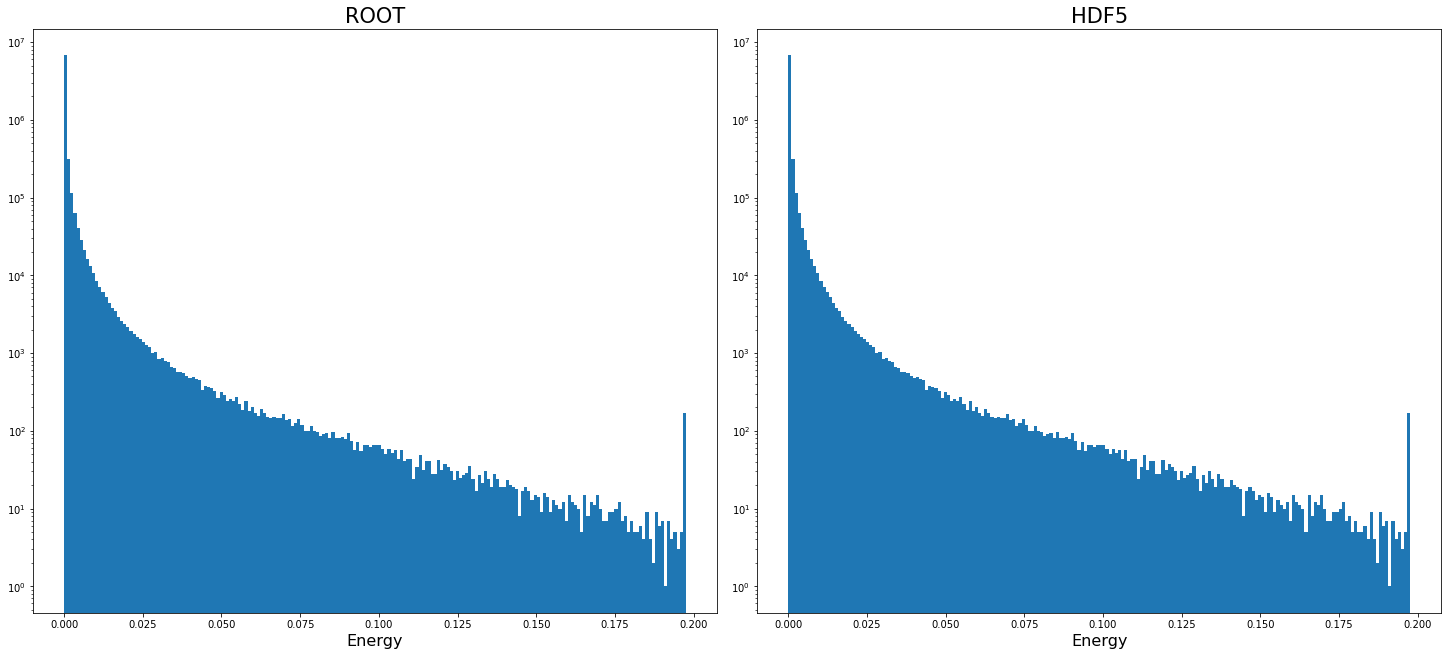

  array length:  200


 Number of differences:  0




<Figure size 432x288 with 0 Axes>

In [11]:
make_comparison_plots( root_hits_e, h5_hits_e, 'Energy' )

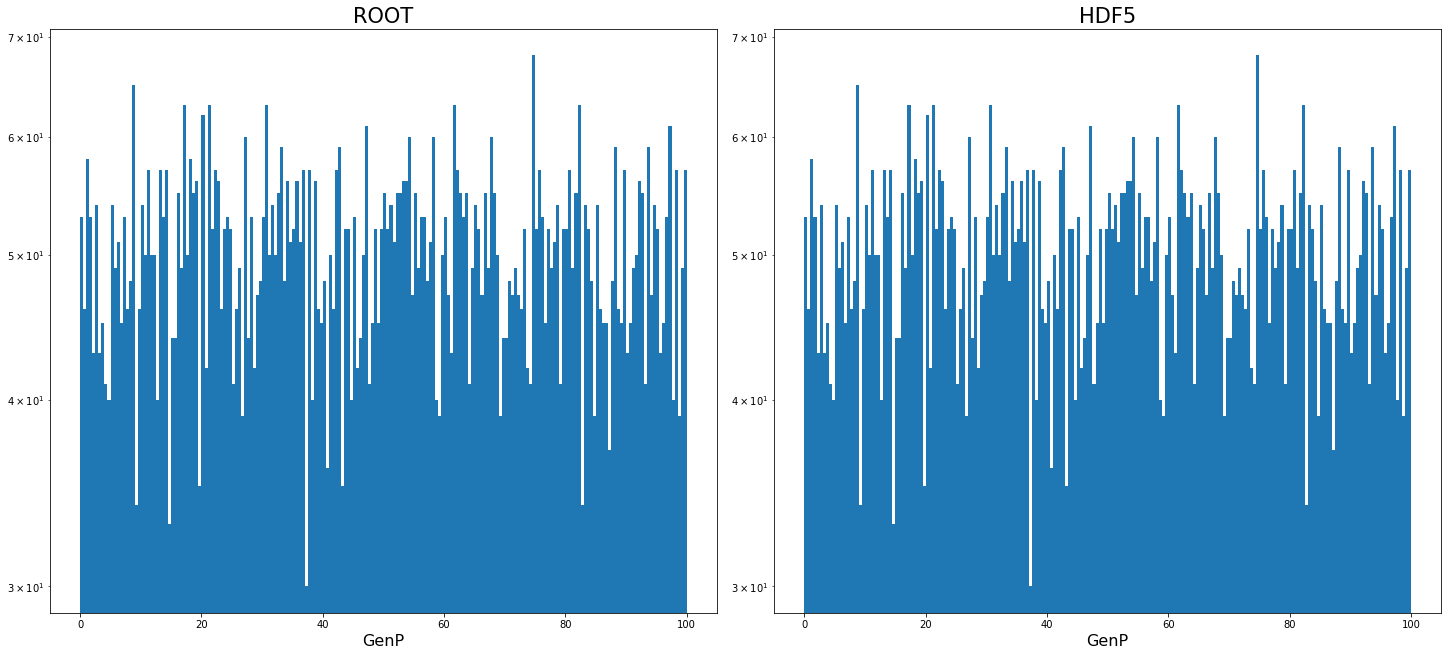

  array length:  200


 Number of differences:  0




<Figure size 432x288 with 0 Axes>

In [12]:
make_comparison_plots( root_gen_P, h5_gen_P, 'GenP' )

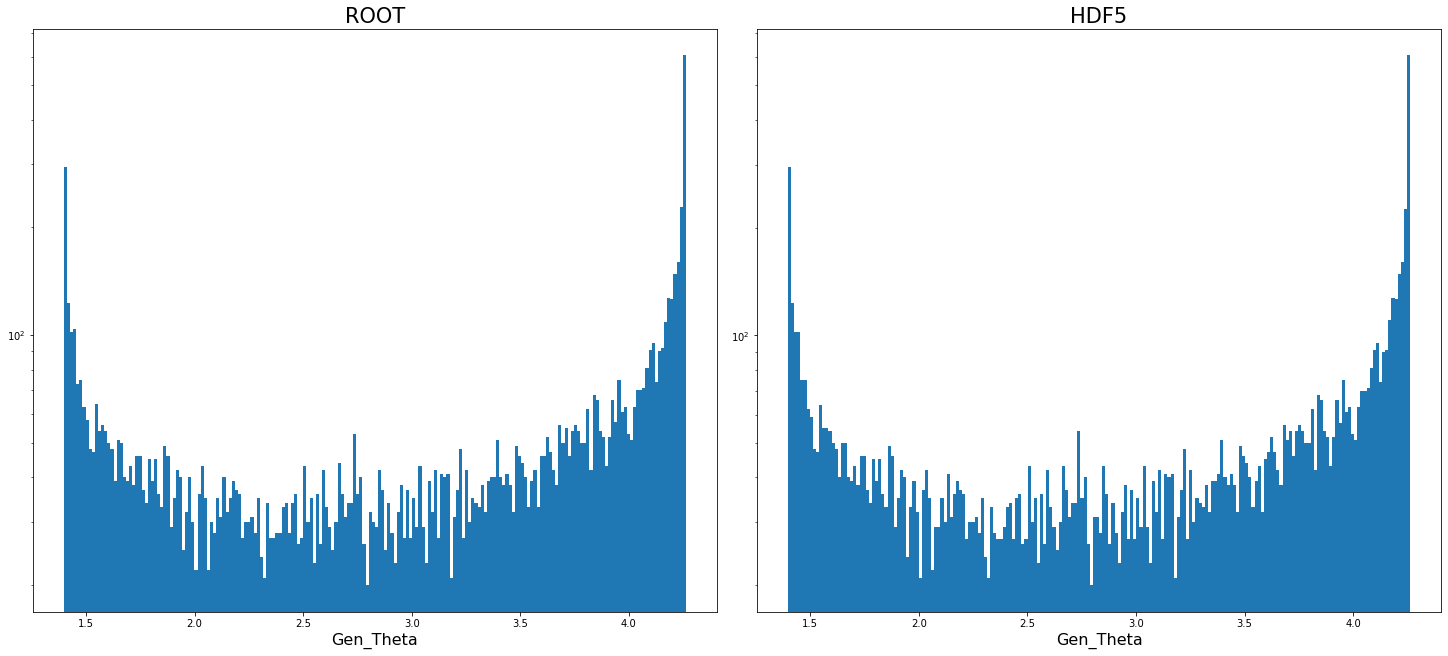

   3  :        104        102  Rectangle(xy=(1.44043, 0), width=0.0143248, height=104, angle=0) *** 2
   4  :         73         75  Rectangle(xy=(1.45476, 0), width=0.0143248, height=73, angle=0) *** -2
   6  :         63         62  Rectangle(xy=(1.48341, 0), width=0.0143248, height=63, angle=0) *** 1
   7  :         58         59  Rectangle(xy=(1.49773, 0), width=0.0143247, height=58, angle=0) *** -1
  11  :         54         55  Rectangle(xy=(1.55503, 0), width=0.0143248, height=54, angle=0) *** -1
  12  :         56         55  Rectangle(xy=(1.56936, 0), width=0.0143248, height=56, angle=0) *** 1
  16  :         39         40  Rectangle(xy=(1.62665, 0), width=0.0143248, height=39, angle=0) *** -1
  17  :         51         50  Rectangle(xy=(1.64098, 0), width=0.0143248, height=51, angle=0) *** 1
  38  :         25         24  Rectangle(xy=(1.9418, 0), width=0.0143248, height=25, angle=0) *** 1
  39  :         32         33  Rectangle(xy=(1.95612, 0), width=0.0143248, height=32, a

<Figure size 432x288 with 0 Axes>

In [13]:
make_comparison_plots( root_gen_Theta, h5_gen_Theta, 'Gen_Theta' )

# Cluster Sum

In [14]:
root_cluster_sum = ak.sum(root_hits_e,axis=-1)
root_cluster_sum = ak.to_numpy(root_cluster_sum)

In [15]:
hdf5_cluster_sum = np.nansum(h5_hits_e,axis=-1)

In [16]:
np.save("%s/raw_cluster_sum_root.npy"%(path),root_cluster_sum)
np.save("%s/raw_cluster_sum_hdf5.npy"%(path),hdf5_cluster_sum)

## Apply Sampling Fraction (Make sure it's for HCal or Hcal insert!!)

In [17]:
root_cluster_sum = root_cluster_sum/sampling_fraction
hdf5_cluster_sum = hdf5_cluster_sum/sampling_fraction

if (do_log):
    
    #first cut away 0
    cluster_mask = root_cluster_sum > min_cluster_E
    root_cluster_sum = root_cluster_sum[cluster_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[cluster_mask]
    h5_gen_P = h5_gen_P[cluster_mask]
    root_gen_P = root_gen_P[cluster_mask]
    
    root_cluster_sum = np.log10(root_cluster_sum)
    hdf5_cluster_sum = np.log10(hdf5_cluster_sum)
    root_gen_P = np.log10(root_gen_P)
    h5_gen_P = np.log10(h5_gen_P)

In [18]:
print(np.any(hdf5_cluster_sum<0.0))

False


In [19]:
print(hdf5_cluster_sum)

[54.249664 87.03489  28.453594 ... 37.623814 79.72064  55.702675]


# Cut on Clusters

In [20]:
cluster_mask = root_cluster_sum > min_cluster_E
if (cut_on_genP):
    cluster_mask = np.logical_and(cluster_mask, root_gen_P > 20.)
if (cut_on_clusters):
    root_cluster_sum = root_cluster_sum[cluster_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[cluster_mask]
    root_gen_P = root_gen_P[cluster_mask]
    root_gen_Theta = root_gen_Theta[cluster_mask]
    h5_gen_P = h5_gen_P[cluster_mask]
    h5_gen_Theta = h5_gen_Theta[cluster_mask]

In [21]:
theta_mask = root_gen_Theta > min_theta
theta_mask = np.logical_and(root_gen_Theta < max_theta,theta_mask)

if (cut_on_genTheta):
    root_cluster_sum = root_cluster_sum[theta_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[theta_mask]
    root_gen_P = root_gen_P[theta_mask]
    root_gen_Theta = root_gen_Theta[theta_mask]
    h5_gen_P = h5_gen_P[theta_mask]
    h5_gen_Theta = h5_gen_Theta[theta_mask]

In [22]:
print(E_Bins)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]


## Cluster Sum and Truth P Correlation

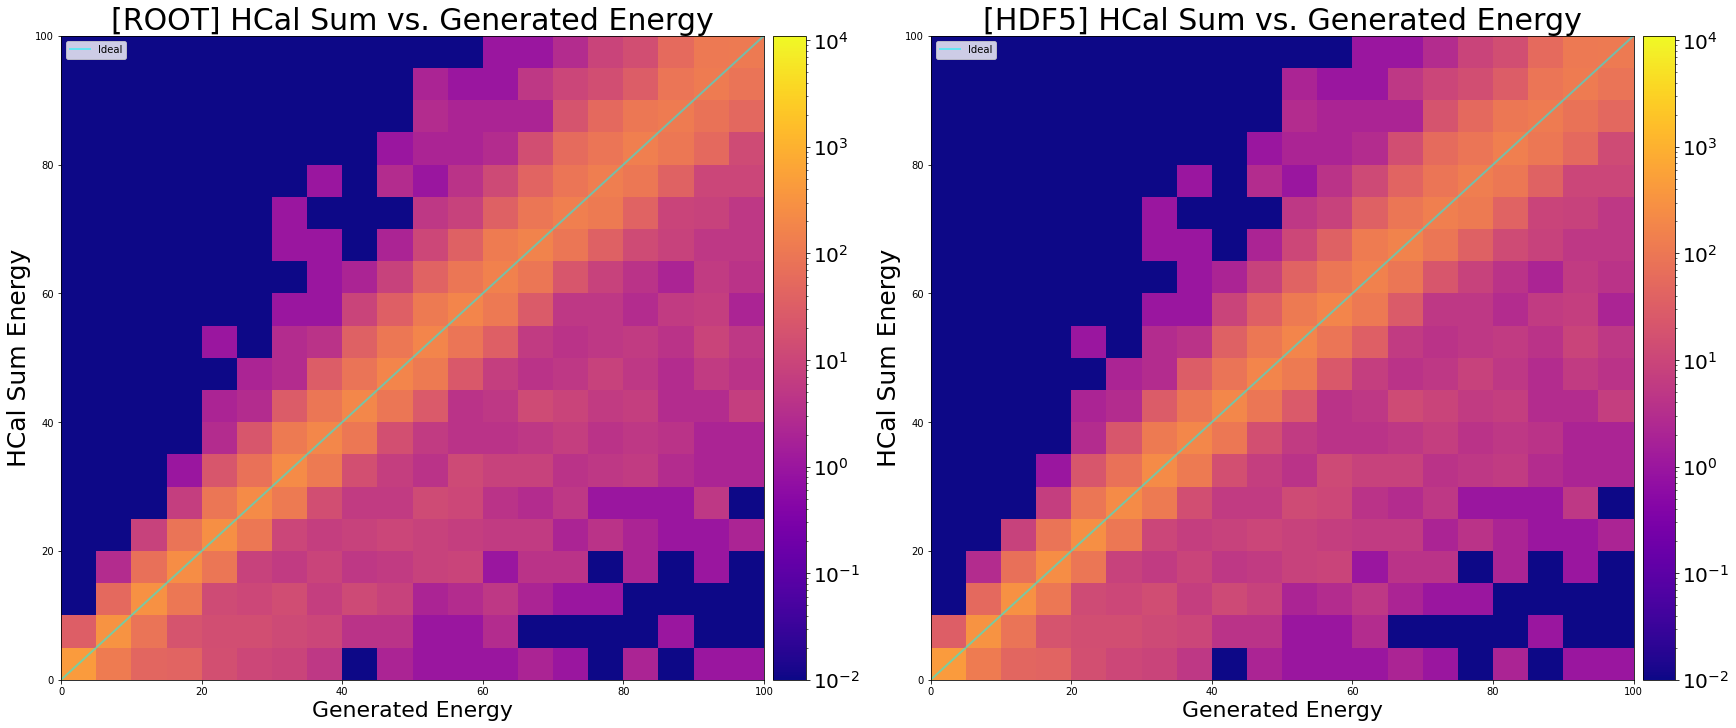

In [23]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), constrained_layout=True)
axes = axes.ravel()
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))

cluster_edges=np.linspace(0,110,1201)
truth_edges=np.linspace(0,100,1201)


#ROOT
h, xedges, yedges = np.histogram2d(root_gen_P, root_cluster_sum, bins=[E_Bins, E_Bins])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=LogNorm(vmin=1.0e-2,vmax=1.1e4), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
axes[0].set_ylabel("HCal Sum Energy",fontsize=25)
axes[0].set_title("[ROOT] HCal Sum vs. Generated Energy",fontsize=30)
axes[0].plot([np.min(E_Bins), np.max(E_Bins)], [np.min(E_Bins), np.max(E_Bins)], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")


#HDF5
h, xedges, yedges = np.histogram2d(h5_gen_P, hdf5_cluster_sum, bins=[E_Bins, E_Bins])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=LogNorm(vmin=1.0e-2,vmax=1.1e4), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[1], pad=0)
cb.ax.tick_params(labelsize=20)
axes[1].set_xlabel("Generated Energy",fontsize=22)
axes[1].set_ylabel("HCal Sum Energy",fontsize=25)
axes[1].set_title("[HDF5] HCal Sum vs. Generated Energy",fontsize=30)
axes[1].plot([np.min(E_Bins), np.max(E_Bins)], [np.min(E_Bins), np.max(E_Bins)], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[1].legend(loc="upper left")

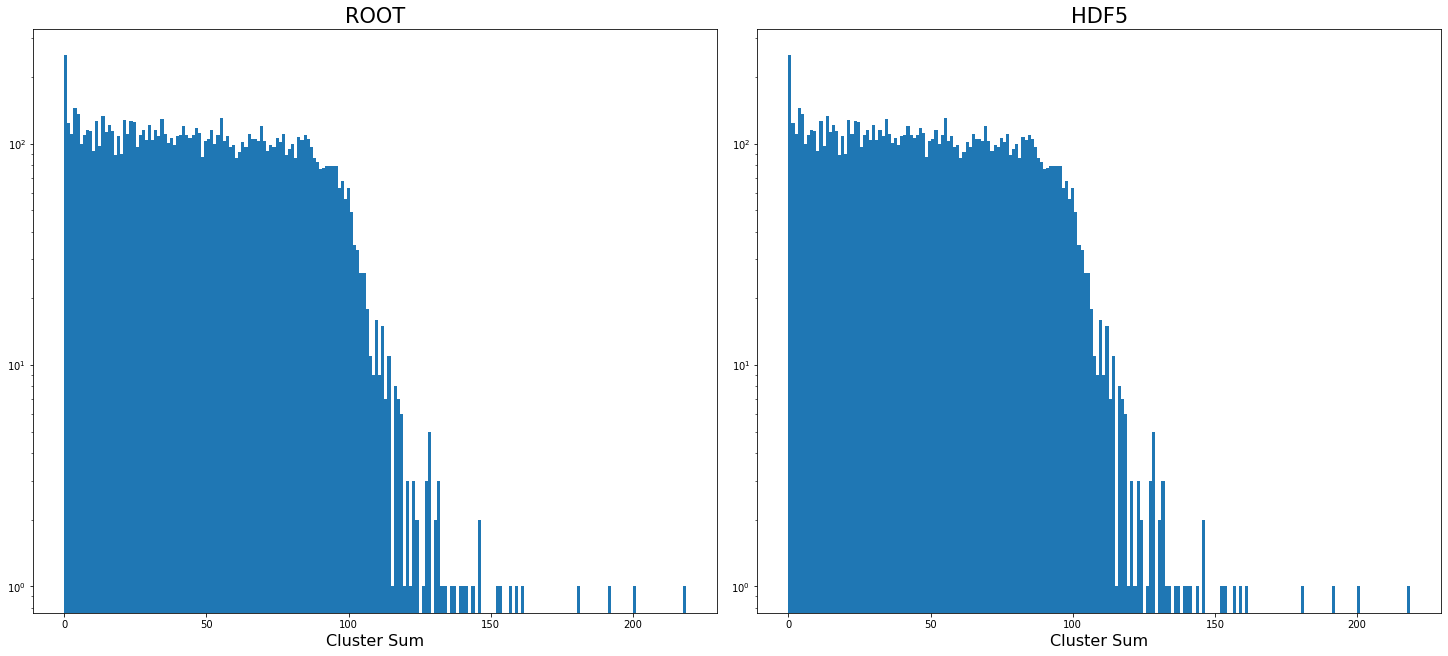

  array length:  200


 Number of differences:  0




<Figure size 432x288 with 0 Axes>

In [24]:
make_comparison_plots( root_cluster_sum, hdf5_cluster_sum, 'Cluster Sum' )

# At this point, it should be established that ROOT and HDF5 data are IDENTICAL

## Last check: Train on HDF5 and ROOT

In [25]:
h5_X = hdf5_cluster_sum
h5_Y = h5_gen_P

R_X = root_cluster_sum
R_Y = root_gen_P

In [26]:
(h5_X_train, h5_X_val, h5_X_test,
h5_Y_train, h5_Y_val, h5_Y_test) = data_split(h5_X, h5_Y, val=0.2, test=0.3,shuffle=shuffle_split)

(R_X_train, R_X_val, R_X_test,
R_Y_train, R_Y_val, R_Y_test) = data_split(R_X, R_Y, val=0.2, test=0.3,shuffle=shuffle_split)

In [27]:
def step_decay(epoch, lr):
    min_rate = 1.01e-7
    N_start = 10
    N_epochs = 5
    
    return lr
    
    if epoch >= N_start and lr >= min_rate:
        if (epoch%N_epochs==0):
            return lr * 0.1
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=0)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [29]:
#from tensorflow.keras.layers import Input
h5_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 3rd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 4th hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

h5_model.compile(loss=loss, optimizer="adam")

h5_fit = h5_model.fit(h5_X_train, h5_Y_train, epochs=100,
                    validation_data=(h5_X_val,h5_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


R_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(64, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 3rd hiddden layer
    tf.keras.layers.Dense(64, activation='relu'), # 4th hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

R_model.compile(loss=loss, optimizer="adam")

R_fit = R_model.fit(R_X_train, R_Y_train, epochs=100,
                    validation_data=(R_X_val,R_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


Epoch 1/100


2023-01-12 12:17:14.068716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2023-01-12 12:17:14.068749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-12 12:17:14.069277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

5/5 [==============================] - 0s 32ms/step - loss: 46.9978 - val_loss: 43.5590 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 42.5871 - val_loss: 38.4859 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 36.4852 - val_loss: 30.8870 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 27.4285 - val_loss: 19.8244 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 14.5891 - val_loss: 6.1140 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 8.5962 - val_loss: 11.6502 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 10.0986 - val_loss: 6.5354 - lr: 0.0010
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 6.5494 - val_loss: 7.2105 - lr: 0.0010
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 7.4828 - val_loss: 6.3016 - lr: 0.0010
Epoch 10

In [30]:
h5_model.save("%s/h5_energy_regression.h5"%(path))
h5_preds = h5_model.predict(h5_X_test,batch_size=400)    
np.save("%s/h5_predictions.npy"%(path),h5_preds)
np.save("%s/h5_y_test.npy"%(path),h5_Y_test)
np.save("%s/h5_x_test.npy"%(path),h5_X_test)

R_model.save("%s/R_energy_regression.h5"%(path))
R_preds = R_model.predict(R_X_test,batch_size=400)    
np.save("%s/R_predictions.npy"%(path),R_preds)
np.save("%s/R_y_test.npy"%(path),R_Y_test)
np.save("%s/R_x_test.npy"%(path),R_X_test)

8/8 [==============================] - 0s 1ms/step


___

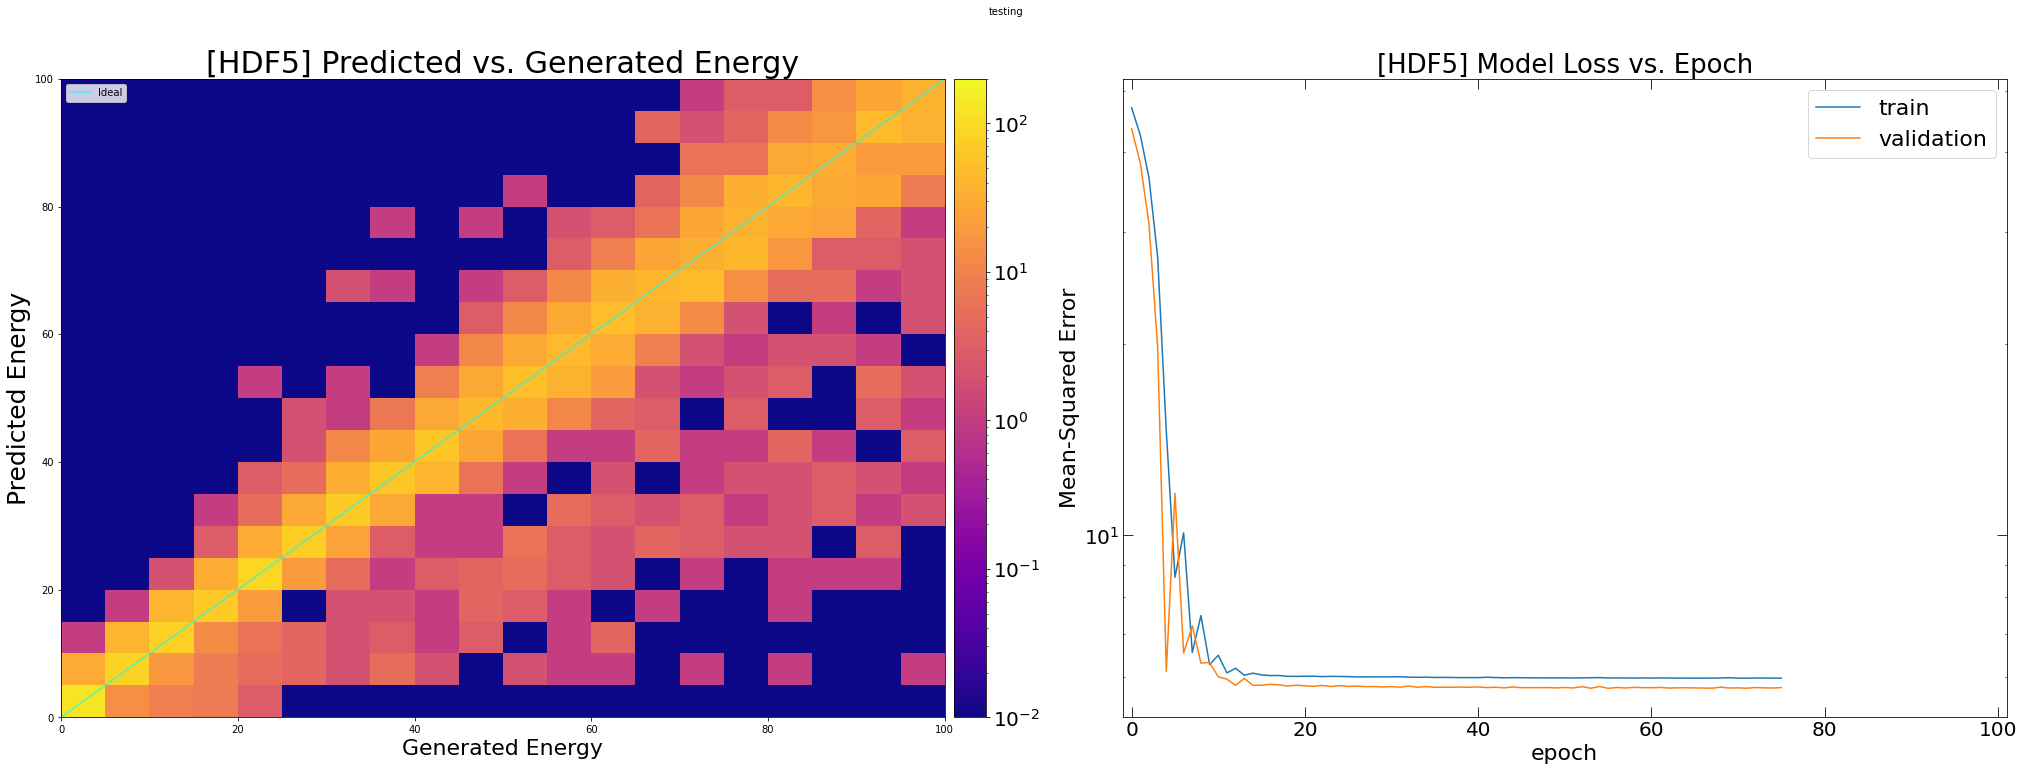

In [31]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
#fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
#fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(h5_Y_test,h5_preds[:,0], bins=[E_Bins, E_Bins])
#xedges=yedges
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap, norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
#cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
#axes[0].set_yticks(fontsize=20)
#axes[0].set_xticks(fontsize=20)
#axes[0].set_ylim(-1,110)
#axes[0].set_xlim(-0,101)
axes[0].plot([np.min(E_Bins), np.max(E_Bins)], [np.min(E_Bins), np.max(E_Bins)], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[HDF5] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(h5_fit.history['loss'])
axes[1].plot(h5_fit.history['val_loss'])
axes[1].set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1,label,transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/H5_Correlation.png"%(path))

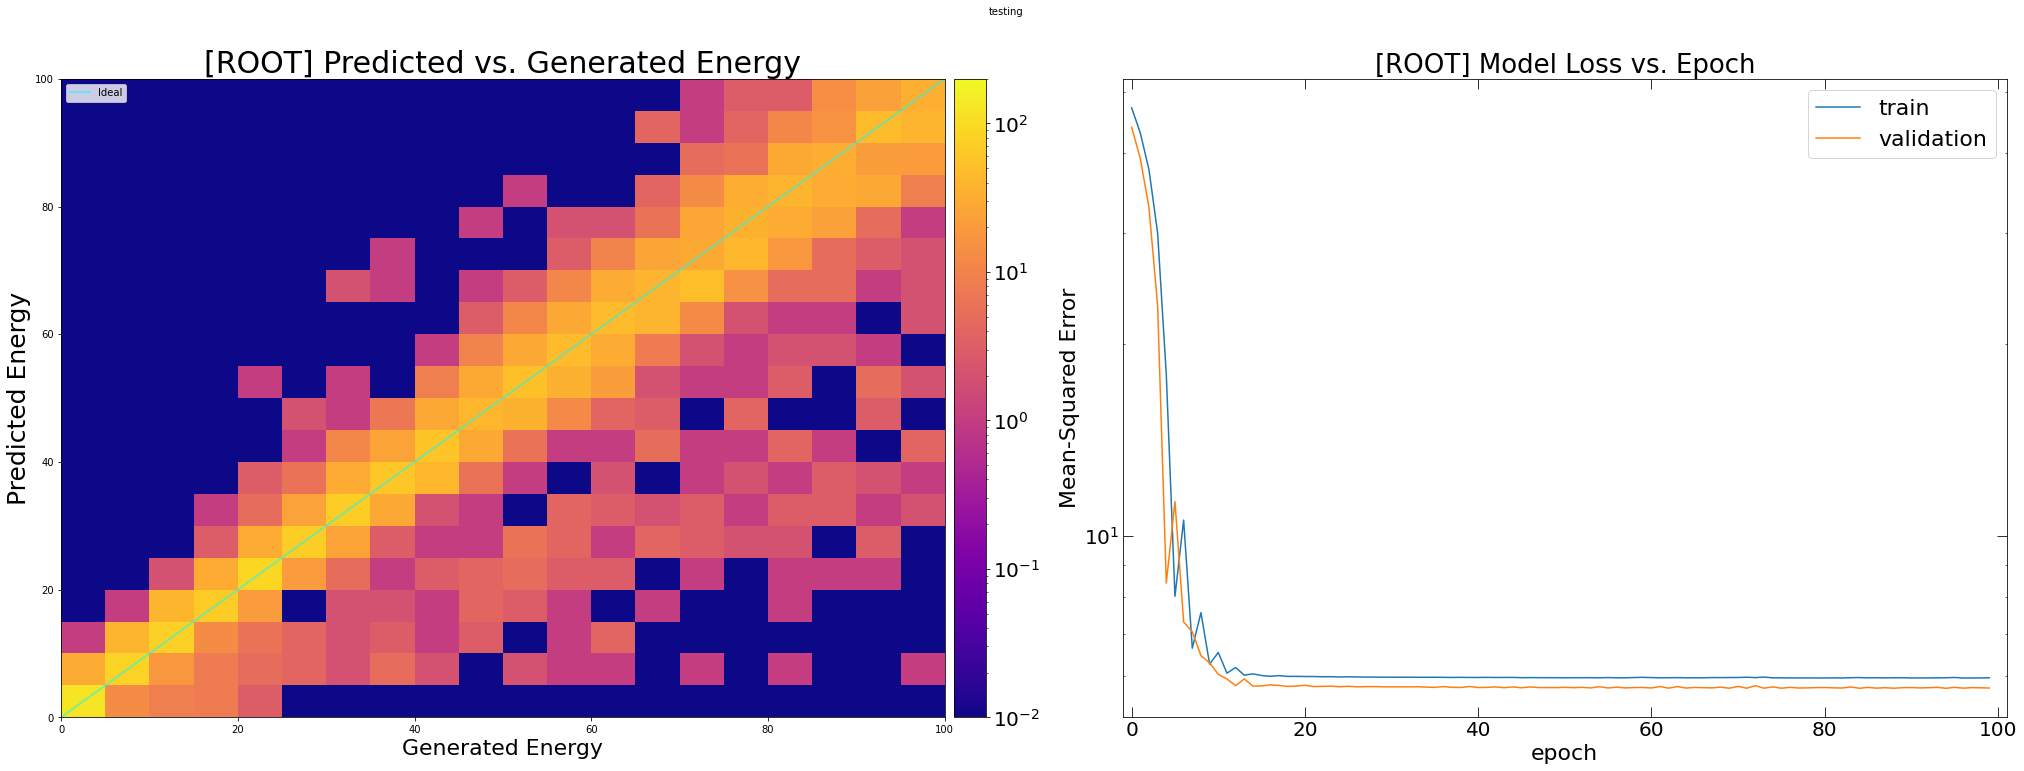

In [32]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(R_Y_test,R_preds[:,0], bins=[E_Bins, E_Bins])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
#axes[0].set_ylim(-1,110)
#axes[0].set_xlim(-0,101)
axes[0].plot([np.min(E_Bins), np.max(E_Bins)], [np.min(E_Bins), np.max(E_Bins)], color="cyan",linewidth=2,alpha=0.5,label="Ideal")
axes[0].legend(loc="upper left")
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[ROOT] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(R_fit.history['loss'])
axes[1].plot(R_fit.history['val_loss'])
axes[1].set_title('[ROOT] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1,label,transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/ROOT_Correlation.png"%(path))

In [33]:
star_energies = [12,16,20,25,30,50,60,70]
star_res = [0.18, 0.16, 0.15, 0.14, 0.13, 0.098, 0.092, 0.090]

ECCE_res = [0.15,0.127,0.117,0.121,0.106,0.102,0.092,0.098]
ECCE_energies = [10,20,30,40,50,60,80,100]

In [34]:
%load_ext autoreload
%autoreload 2
from data_functions import get_res_scale

In [35]:
h5_resolution, h5_pred_over_truth, h5_avg_truth,h5_slices = get_res_scale(h5_Y_test,h5_preds,E_Bins)
h5_strawman_res, h5_strawman_scale, h5_avg_truth, h5_strawman_slices = get_res_scale(h5_Y_test,h5_X_test,E_Bins)

R_resolution, R_pred_over_truth, R_avg_truth,R_slices = get_res_scale(R_Y_test,R_preds,E_Bins)
R_strawman_res, R_strawman_scale, R_avg_truth,R_strawman_slices = get_res_scale(R_Y_test,R_X_test,E_Bins)

/clusterfs/ml4hep_nvme2/ftoralesacosta/regressiononly/data_functions.py:71: RuntimeWarning: invalid value encountered in true_divide
  avg_truth = avg_truth/counter
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/clusterfs/ml4hep_nvme2/ftoralesacosta/regressiononly/data_functions.py:76: RuntimeWarning: invalid value encountered in true_divide
  scale = pred_over_truth/counter
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [36]:
print(h5_pred_over_truth)

[1.58045495 1.14976501 1.05075014 1.01441789 1.02894223 1.0096525
 1.01624286 0.99239087 0.97826868 0.9941825  0.9842779  0.98553696
 0.98633057 0.9704681  0.97752038 0.98408964 0.98283079 0.97759092
 0.97527164 0.9713943         nan]


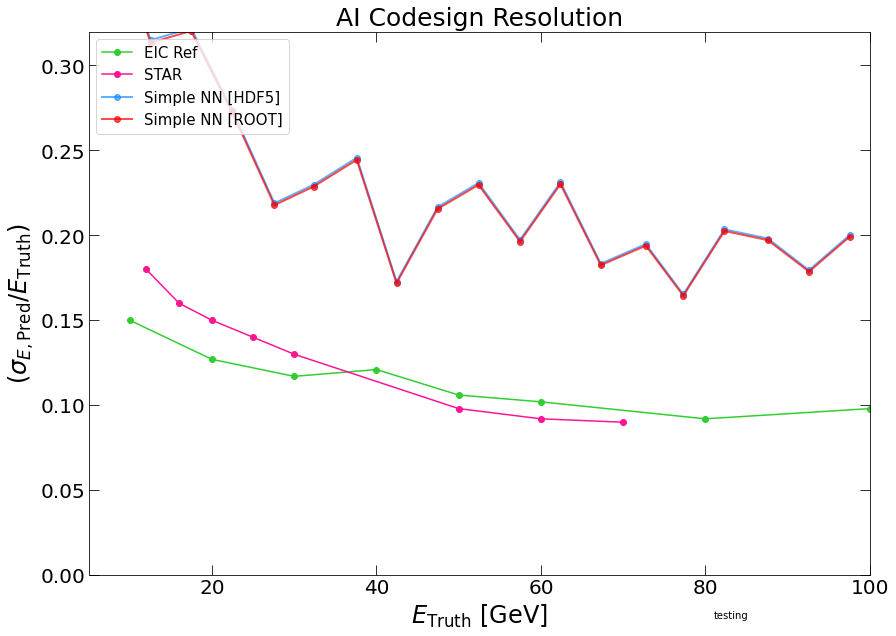

In [37]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,2)
plt.ylim(0,.32)
plt.xlim(-0.01,100.01)
plt.xlim(5.0,100)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = 20

plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_resolution[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7,label="Simple NN [HDF5]")

plt.errorbar(R_avg_truth[first_bin:last_bin],R_resolution[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='red',alpha=0.7,label="Simple NN [ROOT]")

plt.plot(ECCE_energies,ECCE_res,"-o",label = "EIC Ref",color="limegreen")
plt.plot(star_energies,star_res,"-o",label = "STAR",color="deeppink")
plt.legend(fontsize=15,loc="upper left")
plt.savefig("%s/h5_resolution_plot.pdf"%(path))




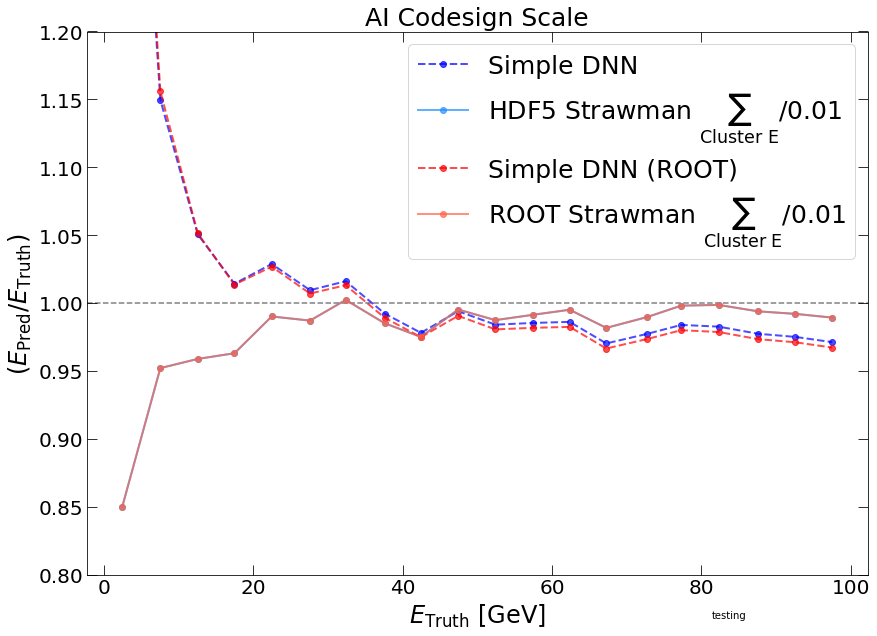

In [38]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.8,1.2)
#plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N_Bins

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'
#HDF5 NN   
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color=color1,alpha=0.7,label="Simple DNN")

#Strawman
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_strawman_scale[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",color=color2,alpha=0.7,label="HDF5 Strawman $\sum_\mathrm{Cluster\ E} / %1.2f$"%(sampling_fraction))


#ROOT NN
plt.errorbar(R_avg_truth[first_bin:last_bin],R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color='red',alpha=0.7,label="Simple DNN (ROOT)")

#ROOT Strawman

plt.errorbar(R_avg_truth[first_bin:last_bin],R_strawman_scale[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",color='tomato',alpha=0.7,label="ROOT Strawman $\sum_\mathrm{Cluster\ E} /  $%1.2f"%(sampling_fraction))

#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)


plt.savefig("%s/%s_scale_plot.pdf"%(path,string))

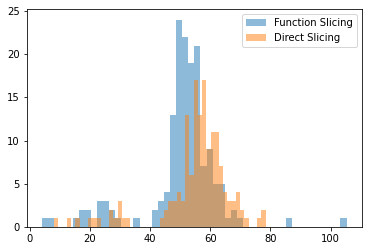

In [39]:
# 48-52 GeV Slice
#look at the distribution of the PRED in that slice
#
#h5_Y_test,h5_preds

mask = (h5_Y_test < 55.)
mask = np.logical_and(mask,h5_Y_test > 50.)
slice_n = int(len(E_Bins)/2)+1
#h5_X_test = Strawman [HDF5]pre
plt.hist(h5_X_test[mask],bins=50, label="Function Slicing",alpha=0.5)
plt.hist(h5_strawman_slices[slice_n],bins=50,label="Direct Slicing",alpha=0.5)
#plt.hist(h5_strawman_slices[9],bins=50,label="Direct Slicing -1 Bin",alpha=0.5)
#plt.hist(h5_strawman_slices[11],bins=50,label="Direct Slicing +1 Bin",alpha=0.5)
plt.legend()


/tmp/ipykernel_32653/205105441.py:16: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(h5_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))


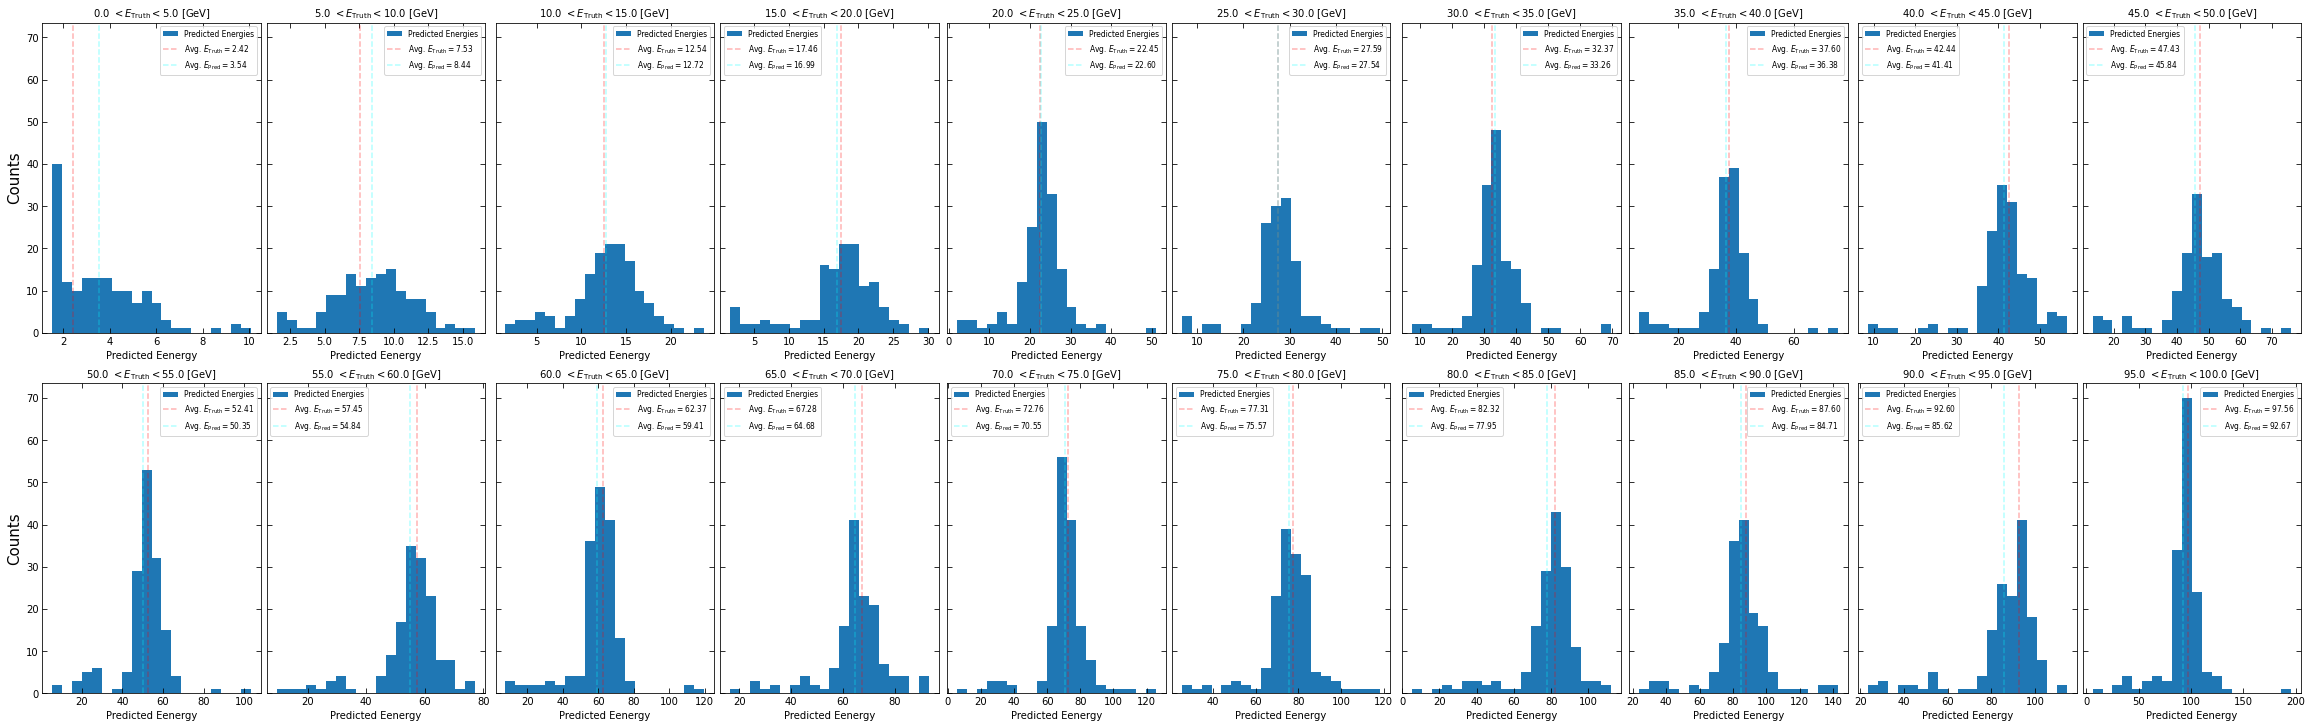

In [40]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    if (np.all(np.isnan(h5_slices[i]))): continue
    temp_bin = np.linspace(h5_avg_truth[i]-2.0,h5_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(h5_slices[i],label="Predicted Energies",bins=20)
    ax.axvline(x=h5_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(h5_avg_truth[i]))
    ax.axvline(x=np.nanmean(h5_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/h5_resolutions_slices.pdf"%(path))

/tmp/ipykernel_32653/3531991872.py:17: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(R_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))


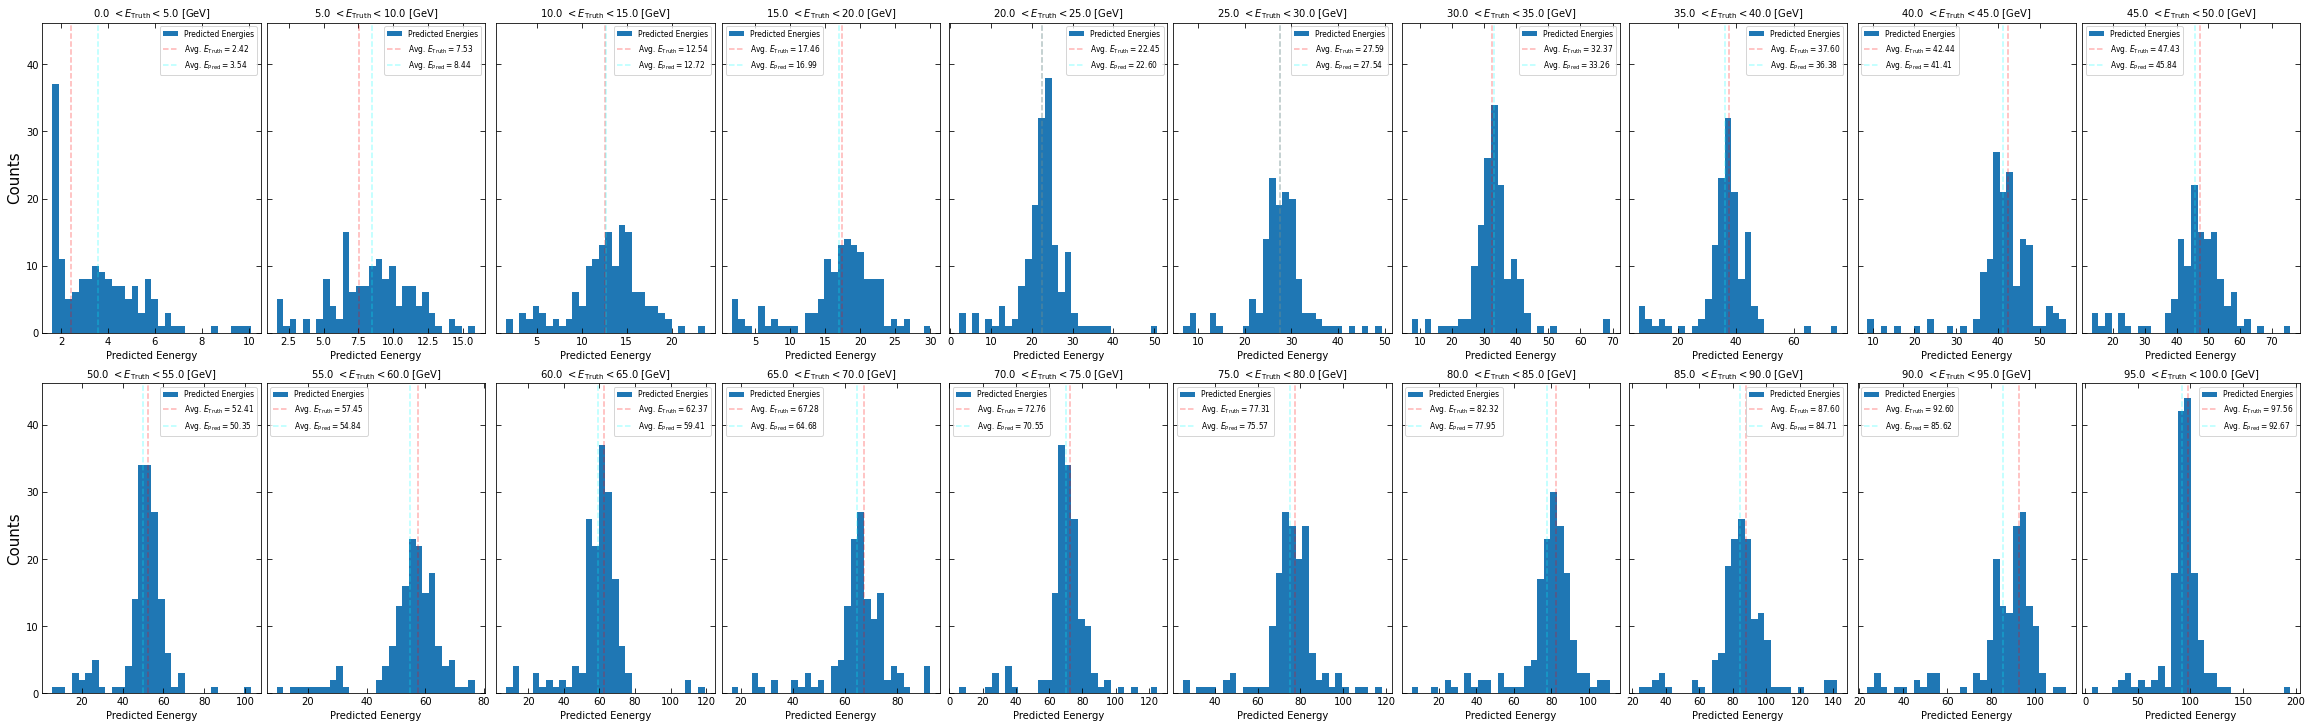

In [41]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)

    if (np.all(np.isnan(R_slices[i]))): continue
    temp_bin = np.linspace(R_avg_truth[i]-2.0,R_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(R_slices[i],label="Predicted Energies",bins=30)
    ax.axvline(x=R_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(R_avg_truth[i]))
    ax.axvline(x=np.nanmean(R_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/R_resolutions_slices.pdf"%(path))

/tmp/ipykernel_32653/3927039482.py:16: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(h5_strawman_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_strawman_slices,axis=-1)[i]))


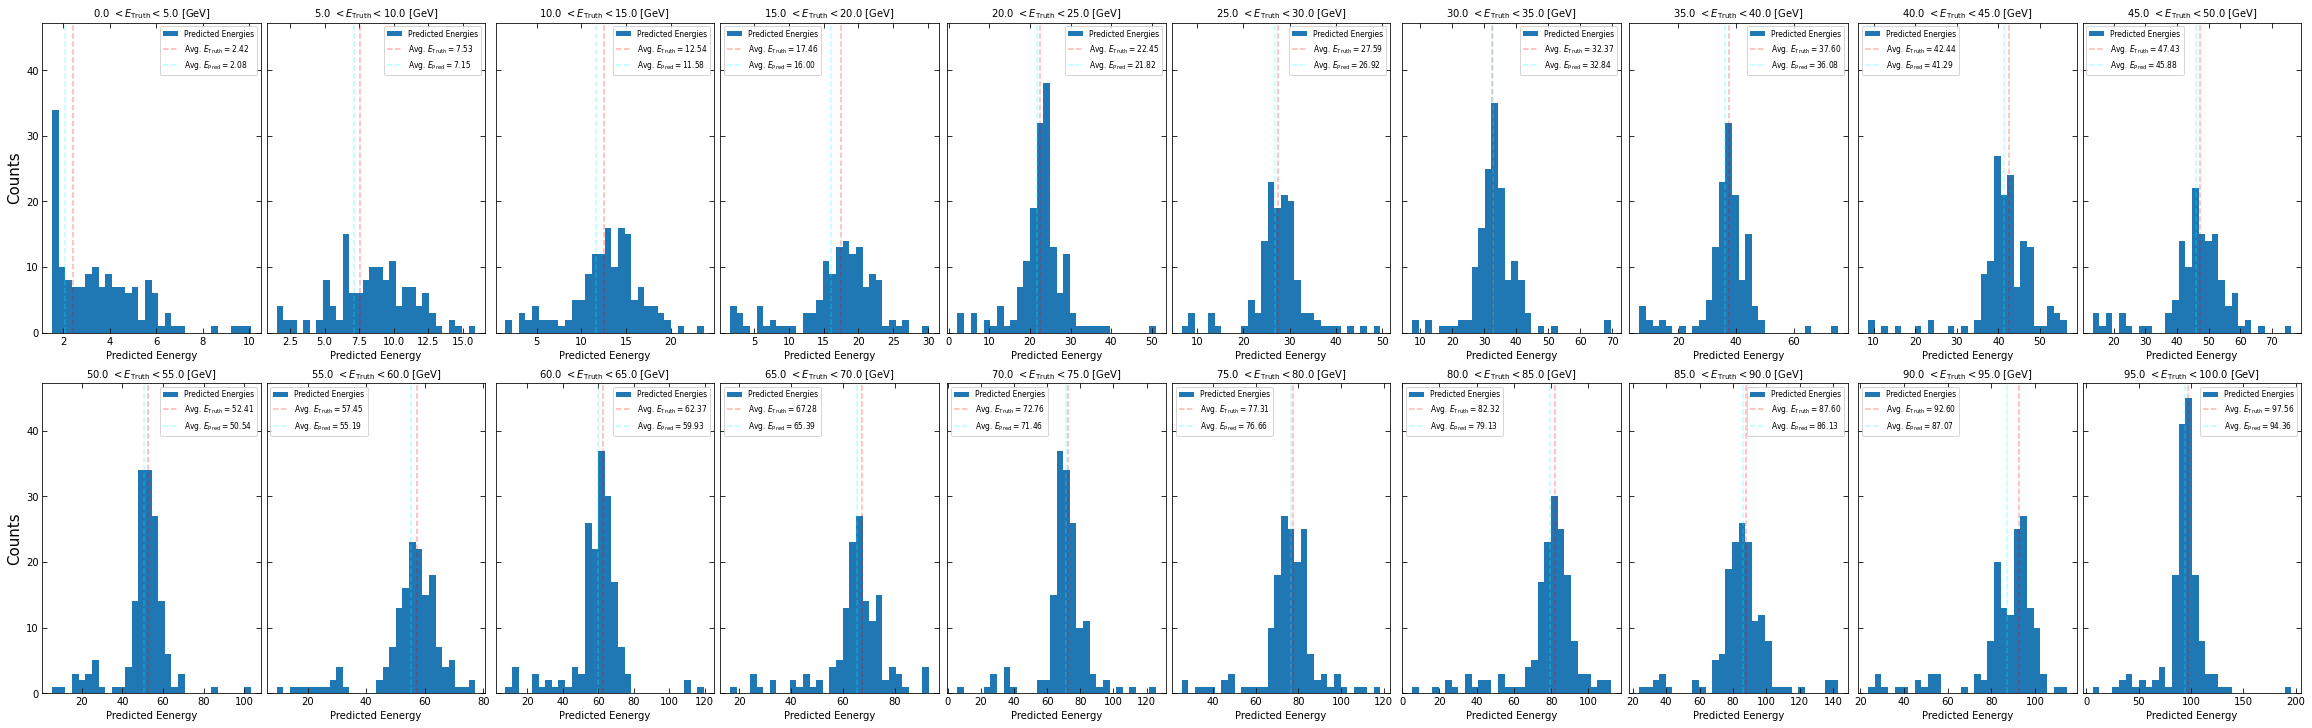

In [42]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    if (np.all(np.isnan(h5_strawman_slices[i]))): continue
    temp_bin = np.linspace(h5_avg_truth[i]-2.0,h5_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(h5_slices[i],label="Predicted Energies",bins=30)
    ax.axvline(x=h5_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(h5_avg_truth[i]))
    ax.axvline(x=np.nanmean(h5_strawman_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_strawman_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/h5_strawman_resolutions_slices.pdf"%(path))

#h5_strawman_res, h5_strawman_scale, h5_avg_truth, h5_strawman_slices

# Let's see what the scale and resolution look like in Bins of Reco (Input) Energy

In [43]:
from data_functions import get_res_scale_in_reco_bins

%load_ext autoreload
%autoreload 2
from data_functions import get_res_scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
reco_h5_resolution, reco_h5_pred_over_truth, reco_h5_avg_reco, reco_h5_avg_truth, reco_h5_slices = get_res_scale_in_reco_bins(h5_Y_test,h5_preds,h5_X_test,np.linspace(0,100,22))
#reco_h5_strawman_res, reco_h5_strawman_scale, reco_h5_avg_truth, reco_h5_strawman_slices = get_res_scale(h5_Y_test,h5_X_test)

reco_R_resolution, reco_R_pred_over_truth, reco_R_avg_reco, reco_R_avg_truth, reco_R_slices = get_res_scale_in_reco_bins(R_Y_test,R_preds,R_X_test,np.linspace(0,100,22))
#R_strawman_res, R_strawman_scale, R_avg_truth,R_strawman_slices = get_res_scale(R_Y_test,R_X_test)

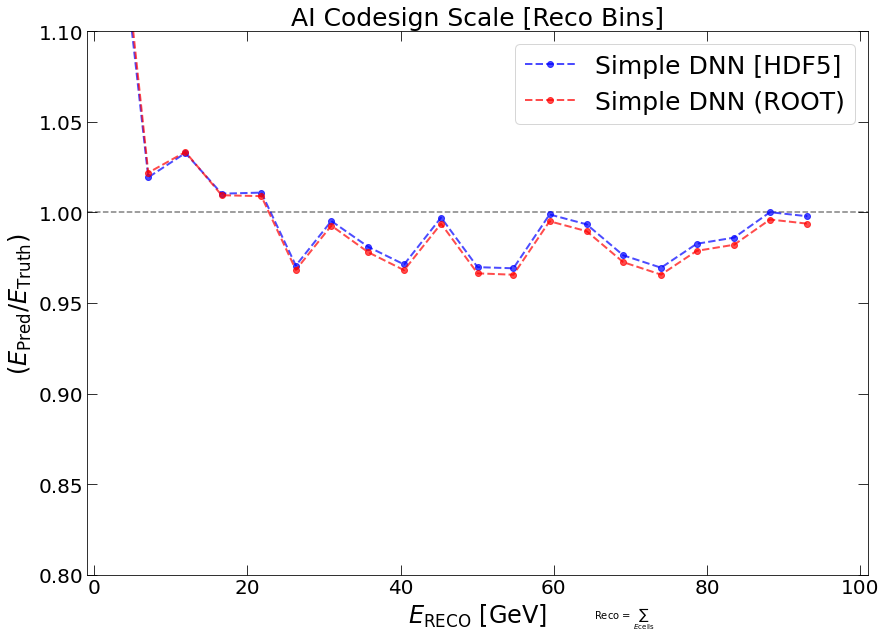

In [45]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale [Reco Bins]",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{RECO}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.8,1.1)
plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N_Bins

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'
#HDF5 NN   
plt.errorbar(reco_h5_avg_reco[first_bin:last_bin],reco_h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color=color1,alpha=0.7,label="Simple DNN [HDF5]")


#ROOT NN
plt.errorbar(reco_R_avg_reco[first_bin:last_bin],reco_R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color='red',alpha=0.7,label="Simple DNN (ROOT)")


#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
#plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)

plt.text(0.65,-0.08,"Reco = $\sum_{E \mathrm{cells}}$",transform=ax.transAxes,fontsize=10)




plt.savefig("%s/Reco_Bins_%s_scale_plot.pdf"%(path,string))

##### If Normalization is desired